# Planaria single-cell

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import pyemb as eb

## Load data

This section uses [data](https://shiny.mdc-berlin.de/psca/) from the paper ['Cell Type Atlas and Lineage Tree of a Whole Complex Animal by Single-Cell Transcriptomics'](https://www.science.org/doi/abs/10.1126/science.aaq1723). It contains expression levels of $p= 5821$ genes measured across $n=5000$ individual cells from adult planarians, a type of flatworm. Such data offer the possibility of discovering the cell lineage tree of an entire animal: the
aim is to find out if the data reflect the tree-structured process by which stem cells differentiate into a variety of distinct cell types. These data were prepared using the Python package [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), where the script on how to do this can be found [here](https://nbviewer.org/github/rajewsky-lab/planarian_lineages/blob/master/paga/preprocessing.ipynb).

In [2]:
Y = np.array(pd.read_csv('data/planaria_sample_data.csv', index_col=0))
(n,p) = Y.shape
print('Data matrix is', n, 'samples by', p, 'features')

labels = np.genfromtxt('data/sample_annotation_5000.txt', delimiter=',', dtype=str) 
ordered_cats = np.genfromtxt('data/planaria_ordered_cats.csv', delimiter=',', dtype=str)

colors = pd.read_csv('data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}

Data matrix is 5000 samples by 5821 features


## Dimension selection and visualisation

Perform dimension selection using Wasserstein distances, see [1](https://arxiv.org/pdf/2208.11665) for details.

In [7]:
ws, dim = eb.wasserstein_dimension_select(Y, range(50), split=0.5)
print("Selected dimension: {}".format(dim))

100%|██████████| 50/50 [02:06<00:00,  2.52s/it]

Recommended dimension: 12, Wasserstein distance 53.42931
Selected dimension: 12


Now, perform PCA with the embedding function and visualise. 

In [3]:
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

In [23]:
len([0])

1

In [46]:
if isinstance(pd.factorize(labels)[0], np.ndarray):
    print('yes')

yes


In [42]:
pd.factorize(labels)[0]

array([0, 1, 2, ..., 8, 1, 4])

In [78]:
import matplotlib.pyplot as plt
def snapshot_plot(
    embedding,
    n = None,
    node_labels = None,
    c = None,
    points_of_interest = [0],
    point_labels=[],
    max_cols=4,
    add_legend=False,
    legend_adjust=0,
    max_legend_cols=5,
    **kwargs,
):
    
    if n is None:   
        n = embedding.shape[0]
    if node_labels is None:
        node_labels = np.zeros(n)

    # Subplot for each time point
    num_cols = min(len(points_of_interest), max_cols)
    num_rows = (len(points_of_interest) + num_cols - 1) // num_cols
    fig, axs = plt.subplots(
        figsize=(5 * num_cols, 5 * num_rows),
        sharex=True,
        sharey=True,
        ncols=num_cols,
        nrows=num_rows,
    )

    if len(embedding.shape) == 2:
        T = embedding.shape[0] // n
        embedding = embedding.reshape(T, n, embedding.shape[1])

    if isinstance(c, str) or isinstance(c, np.ndarray) or isinstance(c, list):   
        plot_colours = c
    if isinstance(c, dict):
        plot_colours = [c[l] for l in node_labels]
    if c is None:
        plot_colours = pd.factorize(node_labels)[0]

    for t_idx, t in enumerate(points_of_interest):
        if num_rows == 1:
            if num_cols == 1:
                subplot = axs
            else:
                subplot = axs[t_idx]
        else:
            t_row = t_idx // num_cols
            t_col = t_idx % num_cols
            subplot = axs[t_row, t_col]

        scatter = subplot.scatter(
            embedding[t, :, 0],
            embedding[t, :, 1],
            c=plot_colours,
            **kwargs,
        )

        if len(point_labels) > 0:
            subplot.set_title(point_labels[t_idx])
        else:
            subplot.set_title(f"Time {t}")

        subplot.grid(alpha=0.2)
        subplot.set_xticklabels([])
        subplot.set_yticklabels([])

    # Hide any unused subplots
    if len(points_of_interest) < num_rows * num_cols:
        for idx in range(len(points_of_interest), num_rows * num_cols):
            fig.delaxes(axs.flatten()[idx])

    if add_legend:
        unique_labels = np.unique(node_labels)
        if c is None:
            # Extract and print colormap
            colormap = scatter.get_cmap()
            norm = scatter.norm
            unique_enc_labels = np.unique(plot_colours)
            colours = [colormap(norm(label)) for label in unique_enc_labels]
        else:
            colours = [c[l] for l in unique_labels]
        # Add legend
        handles = []
        labels = []
        for label, colour in zip(unique_labels, colours):
            handles.append(
                plt.Line2D(
                    [0], [0], marker="o", color=colour, linestyle="None", label=label
                )
            )
            labels.append(label)

        fig.legend(
            handles,
            labels,
            loc="lower center",
            ncol=min(len(labels), max_legend_cols),
            bbox_to_anchor=(0.5, legend_adjust),
        )

    return fig


/tmp/ipykernel_7363/3824735260.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = subplot.scatter(


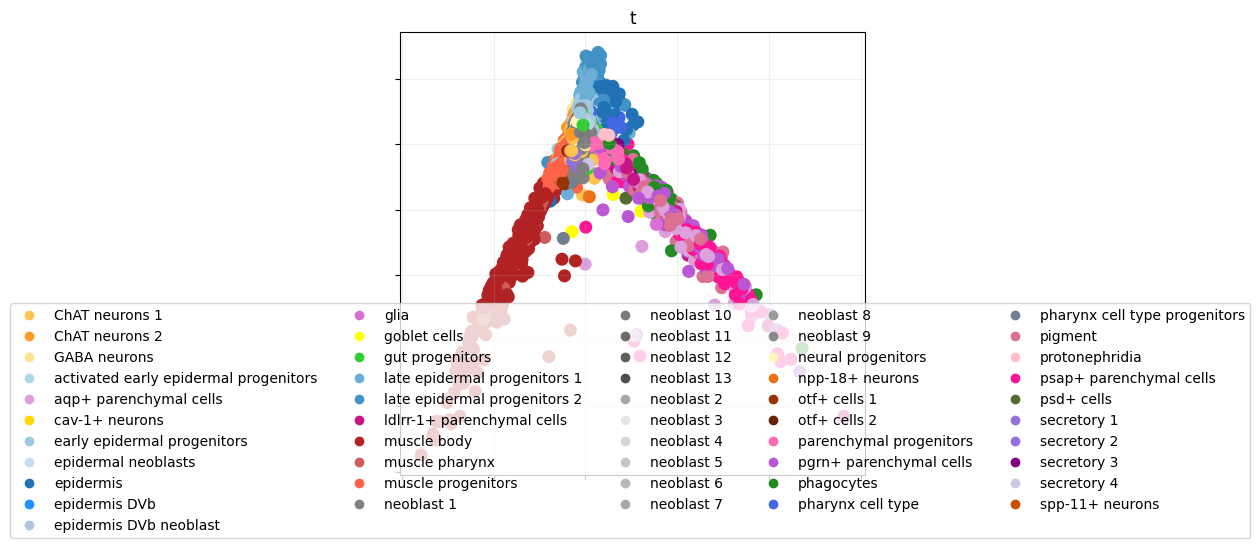

In [79]:
pca_fig = snapshot_plot(
    embedding = zeta, 
    n = n, 
    node_labels = labels, 
    c = colors,
    points_of_interest = [0], 
    point_labels = 'time', 
    add_legend=True, 
    legend_adjust=-0.1,
    
    # Apply other matplotlib settings
    cmap='tab20',
    s=70,
)
plt.tight_layout()

In [4]:
tree = eb.ConstructTree(zeta, epsilon=0.25)
tree.fit()

Performing clustering...
Calculating branch lengths...
Constructing tree...


100%|██████████| 250/250 [00:02<00:00, 100.28it/s]


BarnesHut Approximation  took  1.34  seconds
Repulsion forces  took  0.95  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


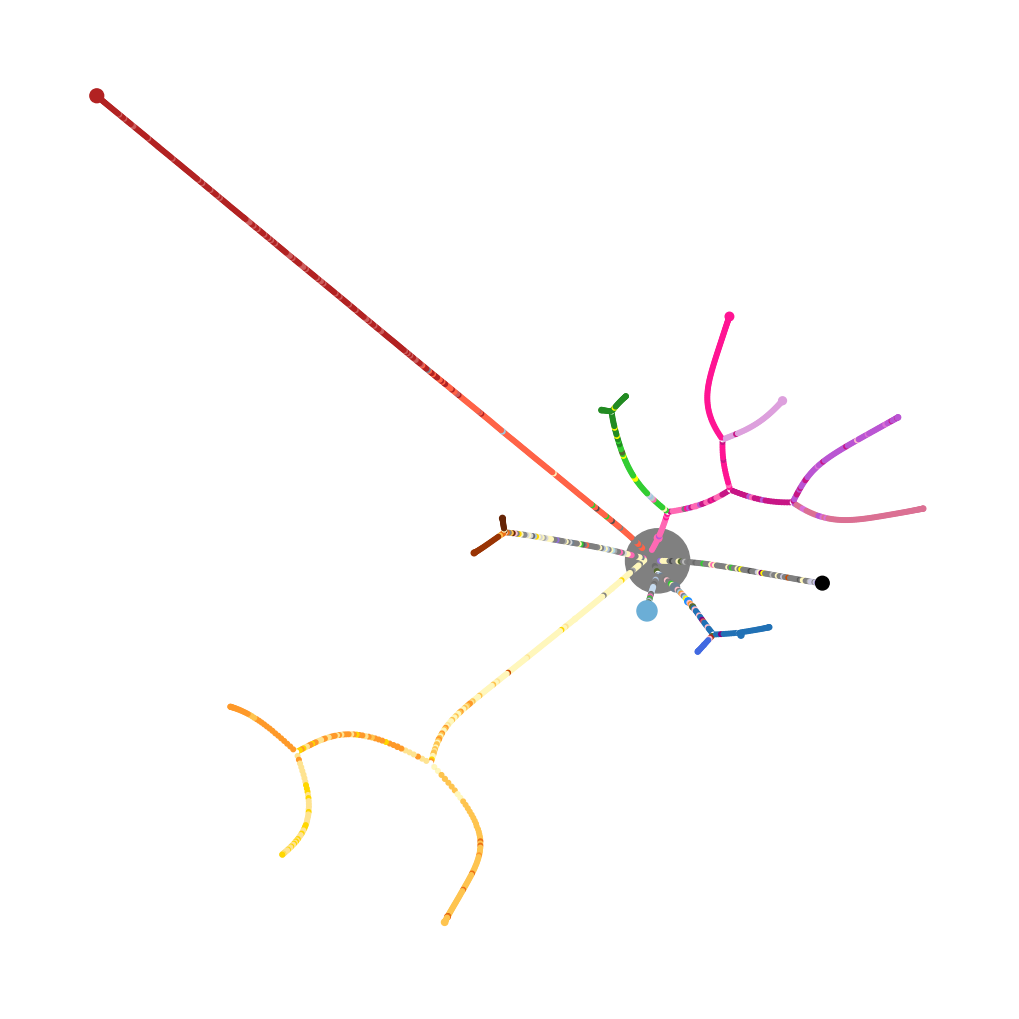

In [5]:
tree.plot(labels,colors, prog = 'twopi')